## **Loading and Preprocessing Data**

In [37]:
#importing Libraries

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [38]:
#Preprocessing
IMAGE_SIZE =256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [39]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/Plant Village',
    labels='inferred',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [40]:
class_names = dataset.class_names

In [41]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [42]:
len(dataset)

68

In [43]:
for image_batch, labels_batch in dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.numpy())

  # there is 32 image in one batch of size 256*256 and the 3 indicates the RGB channel
  # for each 32 images the labels are printed (0 to 2. as we have 3 labels- healthy, Early Light and Late Light)

(32, 256, 256, 3)
[0 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1]


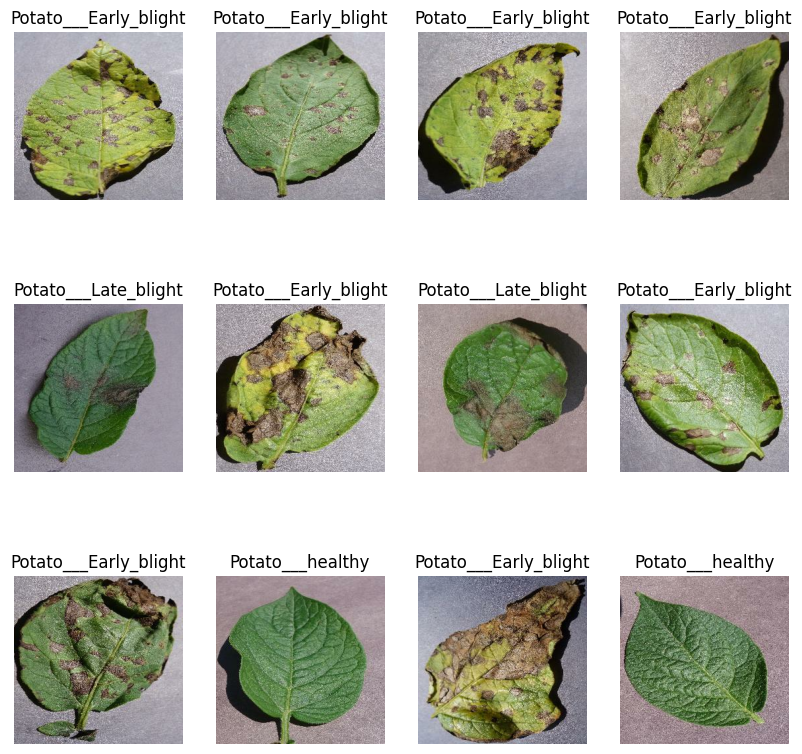

In [44]:
#printing the first image of the first batch
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.axis('off')
    plt.title(class_names[labels_batch[i]])


In [45]:
#splitting the dataset in 80 training 10 validation 10 testing
train_size = 0.8
len(dataset)*train_size
#we get 80 percent of 68

54.400000000000006

In [46]:
train_ds = dataset.take(54)
len(train_ds)

54

In [47]:
remaining_ds = dataset.skip(54)

In [48]:
len(remaining_ds)

14

In [49]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [50]:
val_ds = remaining_ds.take(6)
len(val_ds)

6

In [51]:
test_ds = remaining_ds.skip(6)
len(test_ds)

8

In [52]:
#we cand do partition in one fucntion with random suffling

def get_idataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  train_size = int(train_split*ds_size)
  val_size = int(val_split*ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [53]:
train_ds, val_ds, test_ds = get_idataset_partitions_tf(dataset)

In [54]:
len(train_ds)

54

In [55]:
len(val_ds)

6

In [56]:
len(test_ds)

8

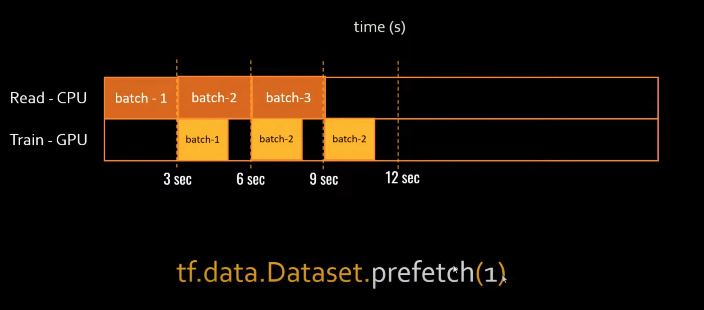

In [57]:
# caching wil read the image from the disk and then keep the image in the memory for the next iteration, improves performances of pipeline
# prefetching load the next set of batch from the disk when GPU is busy on trainning, improves performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [58]:
from tensorflow import keras
from tensorflow.keras import layers

#Scalling
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE), # Update: Removed 'experimental.preprocessing.'
    layers.Rescaling(1.0/255) # Update: Removed 'experimental.preprocessing.'
])

In [59]:
# Data Augmentation

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Update: Removed 'experimental.preprocessing.'
    layers.RandomRotation(0.2)  # Update: Removed 'experimental.preprocessing.'
])

## **Building CNN**

In [60]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
#compiling the model

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# **Training**

In [62]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.4537 - loss: 0.9570 - val_accuracy: 0.5208 - val_loss: 0.8066
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.5712 - loss: 0.7887 - val_accuracy: 0.7135 - val_loss: 0.5169
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.7467 - loss: 0.5369 - val_accuracy: 0.8385 - val_loss: 0.3818
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.8369 - loss: 0.3797 - val_accuracy: 0.8229 - val_loss: 0.3684
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.8563 - loss: 0.3337 - val_accuracy: 0.9062 - val_loss: 0.2459
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.8959 - loss: 0.2463 - val_accuracy: 0.9062 - val_loss: 0.2291
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9302 - loss: 0.1897 - val_accuracy: 0.9115 - val_loss: 0.2128
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9277 - loss: 0.1835 - val_accuracy: 0.8438 -

In [63]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9637 - loss: 0.1378


In [64]:
scores

[0.10929650068283081, 0.97265625]

In [65]:
history

In [66]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [67]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

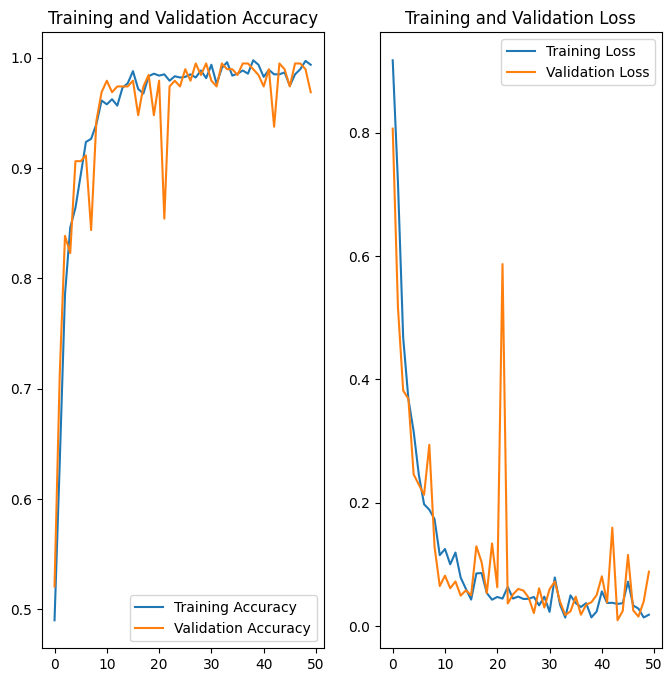

In [69]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#loss chart
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [70]:
import numpy as np

[1 0 2 1 0 0 0 0 0 0 1 1 1 0 2 0 0 1 0 2 0 0 0 1 1 1 1 1 1 1 1 1]
first image to predict
first image's actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
predicted label:  Potato___Late_blight


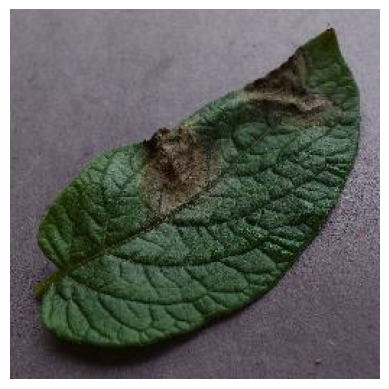

In [71]:
for images_batch, labels_batch in train_ds.take(1):

  print(labels_batch.numpy())
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  print("first image's actual label:", class_names[first_label])
  plt.axis('off')
  plt.imshow(first_image)

  #predict
  batch_prediction = model.predict(images_batch)
  print("predicted label: ", class_names[np.argmax(batch_prediction[0])])

In [72]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])),2)
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


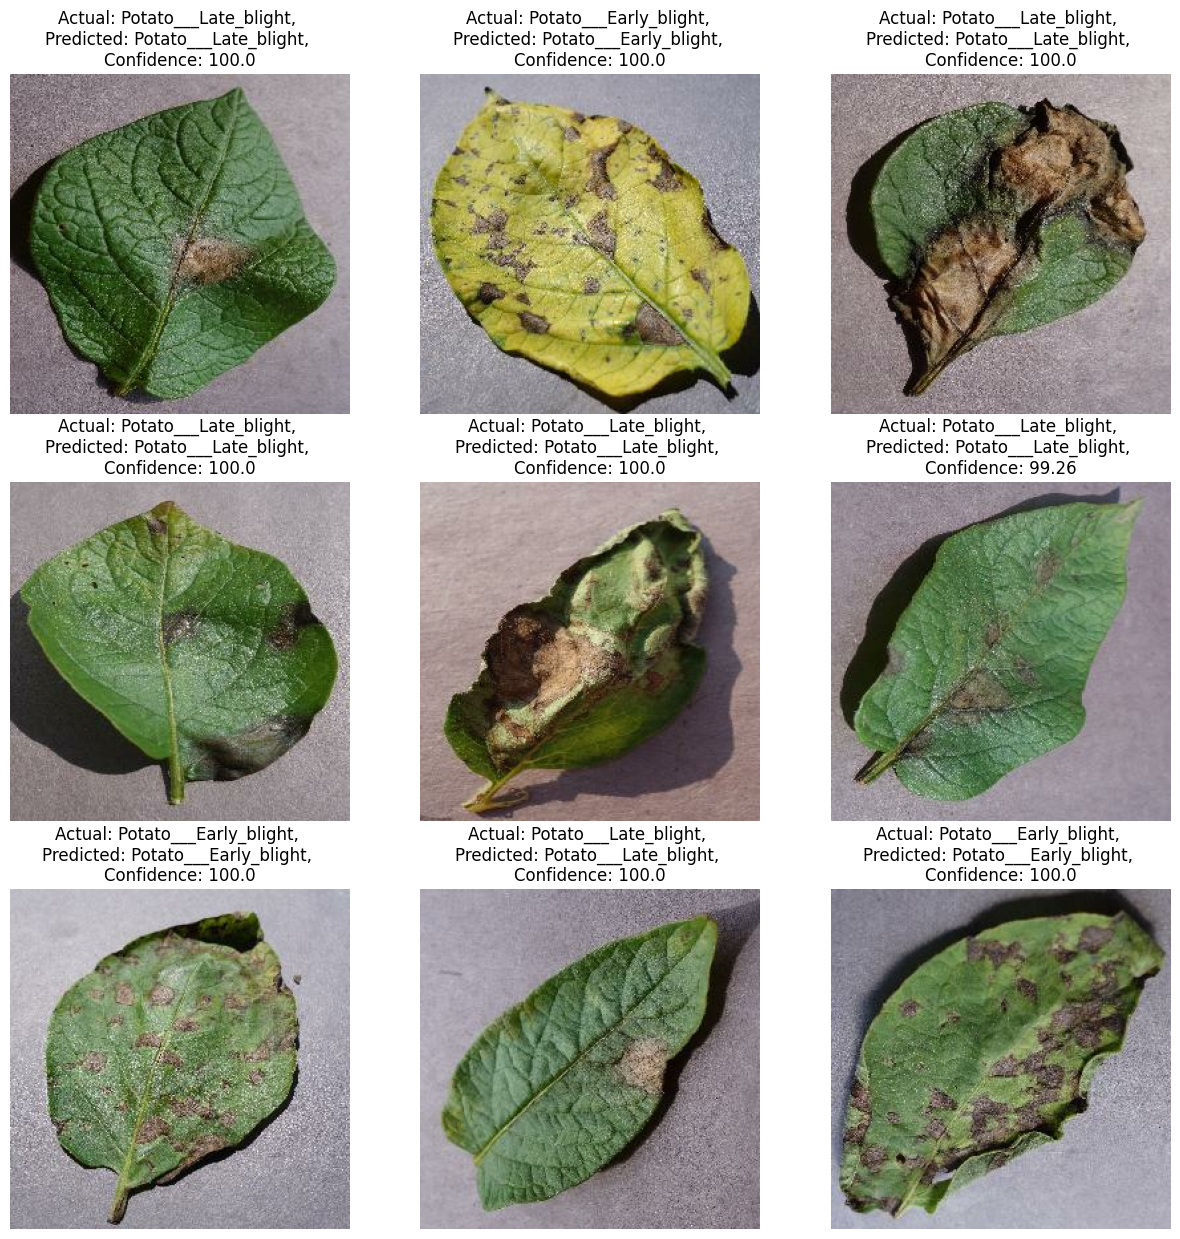

In [73]:
# prediction on entire batch
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}")

    plt.axis("off")


In [79]:

model_version = 1

In [76]:
model.save(f"/content/models/{model_version}.keras")